In [101]:
import math

import pandas as pd
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, accuracy_score,
                             confusion_matrix, roc_auc_score, ConfusionMatrixDisplay)
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('/home/stepbruh/Рабочий стол/JetBrains Projects/DataspellProjects/Datasets/laptops_dataset_final_600.csv')

In [3]:
df.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24113 entries, 0 to 24112
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    24113 non-null  object 
 1   overall_rating  24113 non-null  float64
 2   no_ratings      24113 non-null  object 
 3   no_reviews      24113 non-null  object 
 4   rating          24113 non-null  int64  
 5   title           24113 non-null  object 
 6   review          24113 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB


In [6]:
df['rating'].value_counts()

rating
5    13972
4     5629
3     2035
1     1809
2      668
Name: count, dtype: int64

In [7]:
df.loc[:,['title','review']]

,title,review
0,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Fabulous!,Battery lasted longer than my first relationsh...
2,Fabulous!,Such a great deal.. very happy with the perfor...
3,Delightful,"Awesome build quality and very good display, b..."
4,Awesome,When i ordered and came to know about seller r...
...,...,...
24108,Perfect product!,MSI Laptop is high performance and the best. c...
24109,Perfect product!,Excellent performance best laptop.
24110,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Nice,The product does not support facial recognitio...


In [15]:
df.drop(df[df['rating'] == 3].index, axis=0, inplace=True)

In [16]:
df['sentiment'] = df['rating'].apply(lambda x: 1 if x in [4,5] else 0 )

In [87]:
df['full_text'] = df['title'] + ' ' + df['review']

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [89]:
def lower_replace_punctuation(text: str):
    return ' '.join(re.sub('[^a-zA-Z]',' ',text.lower()).split())

In [88]:
def preprocess_spacy(text: str):
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower() for token in doc
        if token.is_alpha and not token.is_stop and not token.is_punct
    ]
    return ' '.join(lemmas)

In [90]:
df['clean_basic'] = df['full_text'].apply(lambda x: lower_replace_punctuation(x))
df['processed_text'] = df['clean_basic'].apply(preprocess_spacy)

In [91]:
print(df[['full_text', 'processed_text']].head())

                                           full_text  \
0  Perfect product! Loved it, it's my first MacBo...   
1  Fabulous! Battery lasted longer than my first ...   
2  Fabulous! Such a great deal.. very happy with ...   
3  Delightful Awesome build quality and very good...   
4  Awesome When i ordered and came to know about ...   

                                      processed_text  
0       perfect product love s macbook earn hardwork  
1  fabulous battery last long relationship day li...  
2  fabulous great deal happy performance battery ...  
3  delightful awesome build quality good display ...  
4  awesome order come know seller review scared c...  


In [93]:
X = df['processed_text']
y = df['sentiment']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [95]:
print("\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape[0]} объектов")
print(f"Тестовая:  {X_test.shape[0]} объектов")


Размеры выборок:
Обучающая: 17662 объектов
Тестовая:  4416 объектов


In [97]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

In [98]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [99]:
print("\nРазмеры TF-IDF матриц:")
print(f"Обучающая: {X_train_tfidf.shape}")
print(f"Тестовая:  {X_test_tfidf.shape}")


Размеры TF-IDF матриц:
Обучающая: (17662, 10000)
Тестовая:  (4416, 10000)


In [102]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg.predict(X_test_tfidf)
y_pred_proba_logreg = logreg.predict_proba(X_test_tfidf)[:, 1]
print("\nОтчет по классификации (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))


Отчет по классификации (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       495
           1       0.99      1.00      0.99      3921

    accuracy                           0.99      4416
   macro avg       0.99      0.94      0.96      4416
weighted avg       0.99      0.99      0.99      4416



Accuracy (Logistic Regression): 0.9862
ROC AUC Score (Logistic Regression): 0.9921


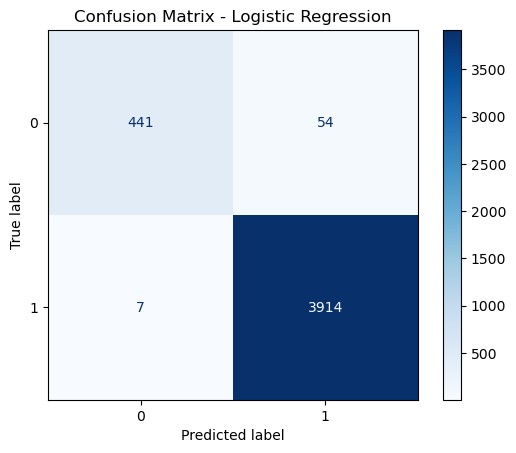

In [106]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
print(f"Accuracy (Logistic Regression): {accuracy_logreg:.4f}")
print(f"ROC AUC Score (Logistic Regression): {roc_auc_logreg:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# XGB

/home/stepbruh/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:55:22] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Отчет по классификации (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       495
           1       0.99      1.00      1.00      3921

    accuracy                           0.99      4416
   macro avg       0.99      0.97      0.98      4416
weighted avg       0.99      0.99      0.99      4416

Accuracy (XGBoost): 0.9918
ROC AUC Score (XGBoost): 0.9964

Матрица ошибок (XGBoost):
[[ 468   27]
 [   9 3912]]


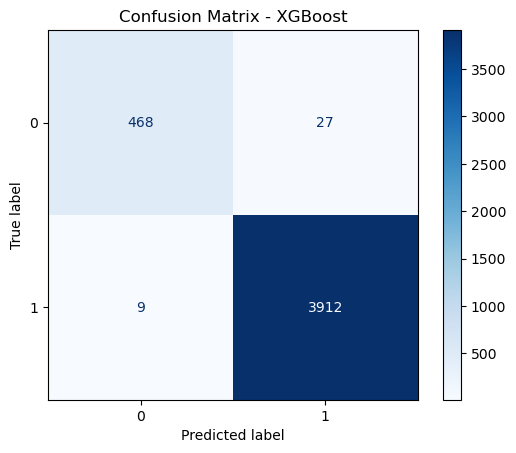

In [108]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric='logloss',
                            use_label_encoder=False,
                            random_state=42)
xgb_clf.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_clf.predict(X_test_tfidf)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test_tfidf)[:, 1]
print("\nОтчет по классификации (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"Accuracy (XGBoost): {accuracy_xgb:.4f}")
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")
print("\nМатрица ошибок (XGBoost):")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()